# Neural Alignment Theory

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns; sns.set_style("whitegrid")

# Translation Symmetry


$$y_1 = \frac{e^{w_1x}}{e^{w_1x} + e^{w_2x}} \qquad y_2 = \frac{e^{w_2x}}{e^{w_1x} + e^{w_2x}}$$

$$$$



# Scale Symmetry


# Inverse Symmetry



$$\mathcal{L}(w_1,w_2) = \frac{1}{2}(y - w_2w_1x)^2$$


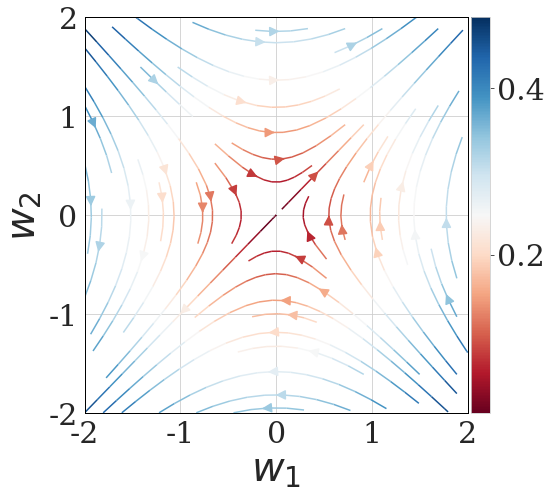

In [113]:
# Plot Specifics
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.locator_params(nbins=3)
    return cbar
fig = plt.figure(figsize=(16,16))
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

def translation(w1, w2):
    dy1 = np.random.randn(1)
    dy2 = np.random.randn(1)
    x = np.random.randn(1)
    
    y1 = np.exp(w1 * x) / (np.exp(w1 * x) + np.exp(w2 * x))
    y2 = np.exp(w2 * x) / (np.exp(w1 * x) + np.exp(w2 * x))
    
    dy1_a1 = y1 - y1**2
    dy1_a2 = -y1 * y2
    dy2_a1 = -y1 * y2
    dy2_a2 = y2 - y2**2
    
    dw1 = (dy1 * dy1_a1 + dy2 * dy2_a1) * x
    dw2 = (dy1 * dy1_a2 + dy2 * dy2_a2) * x
    
    return dw1, dw2

def scale(w1, w2):
    m = 32
    dY = np.random.randn(m)
    X1 = np.random.randn(m)
    X2 = np.random.randn(m)
    
    A = []
    for (x1, x2) in zip(X1, X2):
        A.append(w1 * x1 + w2 * x2)
    
    mu = 0
    for a in A:
        mu += a / m
    
    var = 0
    for a in A:
        var += (a - mu)**2 / m
    std = np.sqrt(var)# + 10**-10)
    
    dA = [0 for i in range(m)]
    for i in range(m):
        # dyi * dyi_dai
        dA[i] += dY[i] * ((1 - 1/m)/std - (A[i]-mu)**2/(m*std**3))
        for j in range(m):
            # dyj * dyj_dai
            if i is not j:
                dA[i] += dY[j] * ((-1/m)/std - (A[j]-mu)*(A[i]-mu)/(m*std**3))
    
    dw1 = 0
    dw2 = 0
    for (da, x1, x2) in zip(dA, X1, X2):
        dw1 += da * x1
        dw2 += da * x2
    
    return dw1, dw2

def inversion(w1, w2):
    dy = np.random.randn(1)
    x = np.random.randn(1)
    
    dw1 = dy * w2 *  x
    dw2 = dy  * w1 * x
    
    return dw1, dw2

# Vector Fields
n = 2
w1, w2 = np.meshgrid(np.linspace(-n, n, 50), np.linspace(-n, n, 50))
dw1, dw2 = inversion(w1, w2)
M = np.hypot(dw1, dw2)

# Plot
ax = fig.add_subplot(221)
plt.xlim(-n, n)
plt.ylim(-n, n)
ax.set_xlabel('$w_1$', size=40, weight='light')
ax.set_ylabel('$w_2$', size=40, weight='light')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_yticks([-n,-n/2,0,n/2,n])
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xticks([-n,-n/2,0,n/2,n])
strm = plt.streamplot(w1, w2, dw1, dw2, color=M, cmap='RdBu', arrowsize=2, density=0.75)
colorbar(strm.lines)
# plt.quiver(w1, w2, dw1, dw2)
for edge in ['bottom','top','right','left']:
    ax.spines[edge].set_linewidth(1)
    ax.spines[edge].set_color('k')
plt.show()
# plt.savefig('wm-large.pdf', format='pdf', bbox_inches='tight')

In [2]:
class Alignment:
    def __init__(self, name):
        self.name = name
    def loss(self, z, w, b):
        raise NotImplementedError
    def gradient(self, w1, w2, b, x, y):
        dW1 = b*(y*x - w2*w1*x*x)
        dW2 = w1*(y*x - w2*w1*x*x)
        return dW1, dW2
    def critical(self):
        raise NotImplementedError
    def trajectory(self, w1_0, w2_0, b_0):
        raise NotImplementedError
    def stability(self, w1,w2,x,y,r,s,lamb):
        raise NotImplementedError

class Backprop(Alignment):
    def __init__(self):
        super(Backprop, self)
    def loss(self, z, w, b):
        return 0
    def gradient(self, w1, w2, b, x, y, update):
        dW1, dW2 = super().gradient(w1, w2, w2, x, y)
        return dW1, dW2, dW2
    def characteristics(self, wmin, wmax, b, n=20):
        r = np.linspace(wmin, wmax, n)
        s = np.linspace(-100,100,1000)
        x = np.outer(np.exp(s),r)
        y = np.outer(np.exp(-s),r)
        return np.hstack((x,x)), np.hstack((y,-y))
    def critical(self):
        return False
    def stability(self, w1,w2,x,y,r,s,lamb):
        return w2
        
class Feedback(Alignment):
    def __init__(self):
        super(Feedback, self)
    def loss(self, z, w, b):
        return 0
    def gradient(self, w1, w2, b, x, y, update):
        dW1, dW2 = super().gradient(w1, w2, b, x, y)
        dB = 0*b
        return dW1, dW2, dB
    def characteristics(self, wmin, wmax, b, n=20):
        r = np.linspace(wmin, wmax, n)
        s = np.linspace(-100,100,1000)
        x = np.outer(np.exp(-s),r)
        y = np.outer(b*s,np.ones(n))
        return x, y
    def critical(self):
        return True
    def stability(self, w1,w2,x,y,r,s,lamb):
        return s*r

class Symmetric(Alignment):
    def __init__(self):
        super(Symmetric, self)
    def loss(self, z, w, b):
        return (w - b)**2
    def gradient(self, w1, w2, b, x, y, update):
        dW1, dW2 = super().gradient(w1, w2, b, x, y)
        if update:
            dW2 = dW2 - 2*(w2 - b)
        dB = 2*(w2 - b)
        return dW1, dW2, dB
    def critical(self):
        return False
    def stability(self, w1,w2,x,y,r,s,lamb):
        return w2 + s*np.sqrt(r)

class Activation(Alignment):
    def __init__(self):
        super(Activation, self)
    def loss(self, z, w, b):
        return (w*z - b*z)**2
    def gradient(self, w1, w2, b, x, y, update):
        dW1, dW2 = super().gradient(w1, w2, b, x, y)
        if update:    
            dW2 = dW2 - 2*(w2*w1*x - b*w1*x)*w1*x
        dB = 2*(w2*w1*x - b*w1*x)*w1*x
        return dW1, dW2, dB
    def critical(self):
        return False
    def stability(self, w1,w2,x,y,r,s,lamb):
        return (w2*w1*x + s*np.sqrt(r))/(w1*x)

class Information(Alignment):
    def __init__(self):
        super(Information, self)
    def loss(self, z, w, b):
        raise NotImplementedError
    def gradient(self, w1, w2, b, x, y, update, lamb=1):
        dW1, dW2 = super().gradient(w1, w2, b, x, y)
        if update:    
            dW2 = dW2 - b*(b*w2 - 1)*x**2 - lamb*w2
        dB = - w2*(b*w2 - 1)*x**2 - lamb*b
        return dW1, dW2, dB
    def critical(self):
        return False
    def stability(self, w1,w2,x,y,r,s,lamb):
        a = w2*(w1*x)**2 / ((w2*w1*x)**2 + lamb)
        b = (r + w2**2*(w1*x)**4 / ((w2*w1*x)**2 + lamb) - lamb*w2**2)/((w2*w1*x)**2 + lamb)
        return a + s*b**0.5
    

class Mirror(Alignment):
    def __init__(self):
        super(Mirror, self)
    def loss(self, z, w, b):
        raise NotImplementedError
    def gradient(self, w1, w2, b, x, y, update, lamb=1):
        dW1, dW2 = super().gradient(w1, w2, b, x, y)
        if update:    
            dW2 = dW2 + b*x**2 - lamb*w2
        dB = w2*x**2 - lamb*b
        return dW1, dW2, dB
    def critical(self):
        return False
    def stability(self, w1,w2,x,y,r,s,lamb):
        a = w2*(w1*x)**2 / lamb
        b = (r + w2**2*(w1*x)**4 / lamb - lamb*w2**2)/ lamb
        return a + s*b**0.5

### Vector Fields and Critical Points

We start by visualizing the vector fields of the various alignment strategies. For a general alignment strategy and learning rate $\eta$, the update is
\begin{align*}
\Delta w_1 &= \eta b(y - w_2w_1x)x\\
\Delta w_2 &= \eta w_1(y - w_2w_1x)x - \eta (\partial \mathcal{R} /\partial w_2)\\
\Delta b &= -\eta (\partial \mathcal{R} /\partial b)
\end{align*}
which as $\eta \to 0$, this gives the coupled system of ODEs
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x - (\partial \mathcal{R} /\partial w_2)\\
\frac{\partial b}{\partial t} &= - (\partial \mathcal{R} /\partial b)
\end{align*}
From this system of ODEs we can determining expressions for the critical points of the various alignment strategies. **Note** you may choose not to include the partial derivative $\partial \mathcal{R} /\partial w_2$ in the update for $w_2$. We still need to better understand how this choice effects the dynamics of the different alignment strategies. You might also consider how scaling the regularization update changes the dynamics.

##### Backpropagation
Backpropagation is defined by the constraint that $b = w_2$ throughout training.  In this case the system of ODEs is reduced to 
\begin{align*}
\frac{\partial w_1}{\partial t} &= w_2(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x
\end{align*}
which has critical points cut out by the expressions
$$w_1 = w_2 = 0 \quad\text{ and }\quad w_1w_2 = \frac{y}{x}$$

##### Feedback Alignment

Feedback alignment is defined by the regularization
$$\mathcal{R}_{\text{FA}} = 0$$
and thus the system of ODEs is 
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x\\
\frac{\partial b}{\partial t} &= 0
\end{align*}
Clearly, $b$ is fixed by its initialization and thus the critical points are cut out by the expressions
$$b = w_1 = 0 \quad\text{ and }\quad w_1w_2 = \frac{y}{x}$$

##### Symmetric Alignment
Symmetric alignment is defined by the regularization
$$\mathcal{R}_{\text{SA}} = \frac{1}{2}(w_2 - b)^2$$
and thus the system of ODEs is 
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x - (w_2 - b)\\
\frac{\partial b}{\partial t} &=  (w_2 - b)
\end{align*}
It's clear from $\frac{\partial b}{\partial t}$ that at all critical points $b = w_2$ and thus the critical points are cut out by the expressions
$$b = w_1 = w_2 = 0 \quad\text{ and }\quad b = w_2,\; w_1w_2 = \frac{y}{x}$$

##### Activation Alignment
Activation alignment is defined by the regularization
$$\mathcal{R}_{\text{AA}} = \frac{1}{2}(w_2x - bx)^2$$
and thus the system of ODEs is 
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x - (w_2 - b)x^2\\
\frac{\partial b}{\partial t} &= (w_2 - b)x^2
\end{align*}
Again, at all critical points $b = w_2$ and thus the critical points are cut out by the expressions
$$b = w_1 = w_2 = 0 \quad\text{ and }\quad b = w_2,\; w_1w_2 = \frac{y}{x}$$

##### Information Alignment
Information alignment is defined by the regularization
$$\mathcal{R}_{\text{IA}} =  \frac{1}{2}(bw_2x)^2 -(bw_2x^2) + \frac{\lambda}{2}(w_2^2 + b^2)$$
and thus the system of ODEs is 
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x - b(bw_2 - 1)x^2 - \lambda w_2\\
\frac{\partial b}{\partial t} &= - w_2(bw_2 - 1)x^2 - \lambda b
\end{align*}
The equation $\frac{\partial w_1}{\partial t}$ implies that at all critical points either $b = 0$ or $w_1w_2 = \frac{y}{x}$.  For information alignment, we also have that $w_2$ and $b$ are the critical points of $L_2$-regularized LAE with input and output $w_1x$:
\begin{align*}
bw_2 &= 1 - \lambda (w_1x)^{-2} \\
b &= w_2
\end{align*}
Together with $w_2 w_1 = \frac{y}{x}$, this implies 
$$w_2^2 = 1 - \lambda \frac{w_2^2}{y^2}$$ 
So for all $\lambda > 0$, the critical points are
$$b = w_1 = w_2 = 0 \quad\text{ and }\quad w_1 = \pm \frac{y}{x}\left(1 + \frac{\lambda}{y^2}\right)^\frac{1}{2}, \; w_2 = b = \pm \left(1 + \frac{\lambda}{y^2}\right)^{-\frac{1}{2}}$$
**Note** these critical points assume the regularization update to $w_2$.  Without this we can solve for $b$ directly and seperate from the critical points of $w_1$ and $w_2$.

##### Weight Mirror
Weight mirror is defined by the regularization
$$\mathcal{R}_{\text{WM}} = -(bw_2x^2) + \frac{\lambda}{2} (w_2^2 + b^2)$$
and thus the system of ODEs is 
\begin{align*}
\frac{\partial w_1}{\partial t} &= b(y - w_2w_1x)x\\
\frac{\partial w_2}{\partial t} &= w_1(y - w_2w_1x)x + bx^2 - \lambda w_2\\
\frac{\partial b}{\partial t} &= w_2x^2 - \lambda b
\end{align*}
Again from the equation $\frac{\partial w_1}{\partial t}$, its clear that at all critical points either $b = 0$ or $w_1w_2 = \frac{y}{x}$.  When $b = 0$, then $w_1 = w_2 = 0$ as well.  More generally, from equation $\frac{\partial b}{\partial t}$, we see that
$$b = \frac{w_2x^2}{\lambda}$$
For nonzero $b$, this implies $\frac{\partial w_2}{\partial t} = 0$ if and only if $\lambda = x^2$, which also leads to alignment.  In otherwords, when $\lambda = x^2$, then the critical points are
$$b = w_2 = w_1 = 0 \quad\text{ and }\quad b = w_2,\; w_1w_2 = \frac{y}{x}$$
otherwise the origin is the only critical point. **Note** if we dont include the regularization update to $w_2$, then there exist more critical points in this case.

In [1]:
@interact_manual(alignment=[('Backpropagation',Backprop),
                     ('Feedback Alignment',Feedback),
                     ('Symmetric Alignment',Symmetric),
                     ('Activation Alignement',Activation),
                     ('Information Alignment',Information),
                     ('Weight Mirror',Mirror)],
                 x=(-10,10,0.1),
                 y=(-10,10,0.1),
                 w=(-4,4,0.1),
                 b=(-4,4,0.1),
                 update=(True))
def visualize(alignment, x, y, b, w, update):

    n = 4
    fig = plt.figure(figsize=(16,16))
    alignment = alignment()

    ### Projected Vector Field (w1, w2) ###
    ax = fig.add_subplot(221)
    plt.title('Horizontal Vector Field (w1, w2)')
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    W1, W2 = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    dW1, dW2, _ = alignment.gradient(W1, W2, b, x, y, update)
    M = np.hypot(dW1, dW2)
    if np.linalg.norm(M):
        strm = plt.streamplot(W1, W2, dW1, dW2, color=M, cmap='RdBu', arrowsize=1)
        plt.colorbar(strm.lines)
    if (x!=0) & (b!=0): # Critical Points
        if alignment.critical():
            w1 = np.linspace(1/1000, n, 1000)
            w2 = (y/x)/w1
            plt.plot(w1, w2, color='red', linewidth=3)
            plt.plot(-w1, -w2, color='red', linewidth=3)
        else:
            plt.scatter(y/x/b, b, color='red')
    
    
    # Characteristic Curves
    if hasattr(alignment, 'characteristics'):
        xr, yr = alignment.characteristics(-n,n, b)
        plt.plot(xr, yr, color='black', linewidth=1)
    
    ### Projected Vector Field (w2, b) ###
    ax = fig.add_subplot(222)
    plt.title('Vertical Vector Field (w2, b)')
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    ax.set_xlabel('w2')
    ax.set_ylabel('b')
    W2, B = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    _, dW2, dB = alignment.gradient(w, W2, B, x, y, update)
    M = np.hypot(dW2, dB)
    if np.linalg.norm(M):
        strm = plt.streamplot(W2, B, dW2, dB, color=M, cmap='RdBu', arrowsize=1)
        plt.colorbar(strm.lines)
    if (x!=0) & (w!=0): # Critical Points
        if alignment.critical():
            b_range = np.linspace(-n, n, 1000)
            w2 = (y/x)/w + 0*b_range
            plt.plot(w2, b_range, color='red', linewidth=3)
        else:
            plt.scatter(y/x/w, y/x/w, color='red')
    
    ### Backpropagation Vector Field (w2 = b) ###
    ax = fig.add_subplot(223)
    plt.title('Backpropagation Vector Field (w2 = b)')
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    W1, W2 = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    dW1, dW2, _ = Backprop().gradient(W1, W2, W2, x, y, update)
    M = np.hypot(dW1, dW2)
    if np.linalg.norm(M):
        strm = plt.streamplot(W1, W2, dW1, dW2, color=M, cmap='RdBu', arrowsize=1)
        plt.colorbar(strm.lines)
    if x != 0: # Critical Points
        w1 = np.linspace(1/1000, n, 1000)
        w2 = (y/x)/w1
        plt.plot(w1, w2, color='red', linewidth=3)
        plt.plot(-w1, -w2, color='red', linewidth=3)
    
    ### 3D Vector Field (w1, w2, b) ###
    ax = fig.add_subplot(224, projection='3d')
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('b')
    ax.set_xlim(-n, n)
    ax.set_ylim(-n, n)
    ax.set_zlim(-n, n)
    # w1, w2 plane
    X, Y = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    Z = b + np.zeros(X.shape)
    ax.plot_wireframe(X, Y, Z, linewidth=1, color='red')
    red_patch = mpatches.Patch(color='red', label='(w1, w2)')
    # w2, b plane
    Y, Z = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    X = w + np.zeros(Y.shape)
    ax.plot_wireframe(X, Y, Z, linewidth=1, color='blue')
    blue_patch = mpatches.Patch(color='blue', label='(w2, b)')
    # w2 = b plane
    X, Y = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    Z = Y
    ax.plot_wireframe(X, Y, Z, linewidth=1, color='green')
    green_patch = mpatches.Patch(color='green', label='(w2 = b)')
    plt.legend(handles=[red_patch, blue_patch, green_patch])
    
    plt.show()

NameError: name 'interact_manual' is not defined

### Dynamics and Trajectories
We now solve for the dynamics of the different alignment strategies through the parameter space from an initial point $w_1(0), w_2(0), b(0)$. 

##### Backpropagation
From the ODEs for $w_1$ and $w_2$, with the added constraint $b = w_2$, we get the following relationship
$$w_2\frac{dw_2}{dt} = w_1 \frac{dw_1}{dt}.$$
Integrating both sides from $0$ to $T$ gives the equation
$$w_2^2(T) - w_2^2(0) = w_1^2(T) - w_1^2(0)$$
which describes the hyberbola
$$\frac{w_2^2(T)}{(w_2^2(0) - w_1^2(0))} - \frac{w_1^2(T)}{(w_2^2(0) - w_1^2(0))} = 1$$
The flow on this hyberbola is found by the vector field.

##### Feedback Alignment
Again from the ODEs for $w_1$ and $w_2$ we get the following relationship
$$b\frac{dw_2}{dt} = w_1 \frac{dw_1}{dt}.$$
Because $b$ is fixed, integrating both sides from $0$ to $T$ gives the equation
$$b(w_2(T) - w_2(0)) = \frac{1}{2}(w_1^2(T) - w_1^2(0))$$
which describes the parabola
$$w_2(T) = \frac{1}{2 b}(w_1^2(T) - w_1^2(0)) + w_2(0)$$
Again, the flow on the parabola is found by the vector field.

##### Symmetric Alignment
In symmetric alignment, $b$ is neither constrained nor fixed, but rather a function of $t$ defined by its own differential equation
$$\frac{db}{dt} = w_2 - b.$$
Parameterizing $b$ by $s = t$, then rearanging and multiplying by $e^{s}$ gives
$$e^s\frac{db}{ds} + e^sb = e^sw_2$$
which by inverse product rule is
$$\frac{d}{ds}(e^s b) = e^sw_2$$
Integrating both sides from $0$ to $t$ gives the equation
$$e^tb(t) - b(0) = \int_0^t e^sw_2 ds$$
which rearanged gives the expression
$$b(t) = e^{-t}\left(\int_0^t e^sw_2 ds + b(0)\right)$$
From the ODEs for $w_1$ and $w_2$ we get the same relationship given by Feedback alignment,  
$$b\frac{dw_2}{dt} = w_1 \frac{dw_1}{dt}.$$
Plugging in the expression for $b(t)$ and integrating from $0$ to $T$ gives the equation
$$\int_0^Te^{-t}\left(\int_0^t e^sw_2 ds + b(0)\right) \frac{dw_2}{dt}dt = \frac{1}{2}(w_1^2(T) - w_1^2(0))$$

##### Activation Alignment
Activation alignment has the same differnetial equation for $b$ given by symmetric alignment multiplied by $(w_1x)^2$, 
$$\frac{db}{dt} = w_2(w_1x)^2 - b(w_1x)^2.$$
We can use the same inverse product rule trick we used in symmetric alignment but multiply by $e^{(w_1x)^2 s}$ instead of $e^{s}$ to get the following expression for $b$
$$b(t) = e^{-(w_1x)^2t}\left((w_1x)^2\int_0^t e^{(w_1x)^2s}w_2 ds + b(0)\right)$$
Again, plugging in the expression for $b(t)$ into the relationship derived from the ODEs for $w_1$ and $w_2$ and integrating from $0$ to $T$ gives the equation
$$\int_0^Te^{-(w_1x)^2t}\left((w_1x)^2\int_0^t e^{(w_1x)^2s}w_2 ds + b(0)\right) \frac{dw_2}{dt}dt = \frac{1}{2}(w_1^2(T) - w_1^2(0))$$
**Note** this is not correct anymore because $w_1$ is a function of $t$ as well.


In [5]:
@interact_manual(w1=(-2,2,0.1),
                 w2=(-2,2,0.1),
                 b=(-2,2,0.1))
def visualize(w1, w2, b):
    
    fig = plt.figure(figsize=(16,8))
    
    ax2 = fig.add_subplot(122)
    
    ax = fig.add_subplot(121, projection='3d') 
    ax.scatter(w1, w2, b)
    ax.scatter(w1, w2, w2)
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('b')
    
    n = 4
    x = np.linspace(-n, n, 1000)
    
    # Backpropagation
    y = np.maximum(x**2 + w2**2 - w1**2, 0)**0.5
    ax.plot(x, y, y, label='Backpropagation', linestyle='dashed', color='orange')
    ax.plot(x, -y, -y, linestyle='dashed', color='orange')
    ax2.plot(x,y)
    ax2.plot(x,-y)
    
    
    # Feedback
    if b != 0:
        y = 1/(2*b)*(x**2 - w1**2) + w2
        ax.plot(x, y, b, label='Feedback Alignment', linestyle='dashed')
        ax2.plot(x,y)
    
    # Kolen-Pollack
    z = np.maximum(x**2 + b**2 - w1**2, 0)**0.5
    y = z - (b - w2)
    ax.plot(x, y, z, label='Kolen-Pollack', color='green', linestyle='dashed')
    y = -z - (b - w2)
    ax.plot(x, y, -z, linestyle='dashed', color='green')
    
    ax2.plot(x,y)
    ax2.plot(x,y)
    
    
    ax.legend()
    
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='w1', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…

In [6]:
@interact_manual(alignment=['Backpropagation','Feedback','Kolen-Pollack'],
                 w1=(-2,2,0.1),
                 w2=(-2,2,0.1),
                 b=(-2,2,0.1),
                 lamb=(0,1,0.01))
def visualize(alignment, w1, w2, b, lamb):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d') 
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('b')
    
    n = 4
    x = np.linspace(-n, n, 1000)
    
    if alignment == 'Backpropagation':
        # Backpropagation with L2 Regularization
        T = np.linspace(0, 10, 10)
        cmap = plt.get_cmap("jet", len(T))

        for i, t in enumerate(T):
            y = np.maximum(x**2 + np.exp(-2*lamb*t)*(w2**2 - w1**2), 0)**0.5
            ax.plot(x, y, y, c=cmap(i))
            ax.plot(x, -y, -y, c=cmap(i))
        ax.scatter(w1, w2, w2)
    
    # Feedback with L2 Regularization
    
    
    # Kolen-Pollack with L2 Regularization
    if alignment == 'Kolen-Pollack':
        T = np.linspace(0, 10, 10)
        cmap = plt.get_cmap("jet", len(T))

        for i, t in enumerate(T):
            z = np.maximum(x**2 + np.exp(-2*lamb*t)*(b**2 - w1**2), 0)**0.5
            y = z - np.exp(-lamb*t)*(b - w2)
            ax.plot(x, y, z, c=cmap(i))
            y = -z - np.exp(-lamb*t)*(b - w2)
            ax.plot(x, y, -z, c=cmap(i))
        ax.scatter(w1, w2, b)
        
    plt.show()

interactive(children=(Dropdown(description='alignment', options=('Backpropagation', 'Feedback', 'Kolen-Pollack…

### Stability and Linearization
Not all of these critical points are stable.  As shown in *Baldi et al*, critical points of Feedback alignment such that the following inequality holds are unstable
$$w_1^2 + w_2b \le 0$$
Clearly, when $b = w_2$ then this inequality only holds for the trivial crtitical point at the origin.  However, for our different alignment stratgies its not so simple.  For fixed $b$, as in feedback alignment, the inequality cuts out a parabola cetered on the $w_2$ axis.  To understand the stability of dynamic alignment stratgies we can explore the gradient flow for a fixed value of the alignment loss (i.e. the level sets of the aliggnment loss).  We explore the following dynamic alignment stratgies and their corresponding expressions for $b$:
\begin{align*}
\text{Symmetric Alignment: }\mathcal{R}(w_2,b) = (w_2 - b)^2 &\implies b = w_2 \pm \sqrt{\mathcal{R}}\\
\text{Activation Alignment: }\mathcal{R}(w_2,b) = (w_2w_1x - bw_1x)^2 &\implies b = w_2 \pm \frac{\sqrt{\mathcal{R}}}{w_1x}\\
\text{Weight Mirror: }\mathcal{R}(w_2,b) = -2bw_2(w_1x)^2 + \lambda (w_2^2 + b^2) &\implies b = \frac{w_2(w_1x)^2}{\lambda} \pm \sqrt{\frac{\mathcal{R} + \frac{w_2^2(w_1x)^4}{\lambda} - \lambda w_2^2}{\lambda}}\\
\text{Information Alignment: }\mathcal{R}(w_2,b) = (bw_2w_1x)^2 -2bw_2(w_1x)^2 + \lambda (w_2^2 + b^2) &\implies b = \frac{w_2(w_1x)^2}{(w_2w_1x)^2 + \lambda} \pm \sqrt{\frac{\mathcal{R} + \frac{w_2^2(w_1x)^4}{(w_2w_1x)^2 + \lambda} - \lambda w_2^2}{(w_2w_1x)^2 + \lambda}}
\end{align*}
Plugging these expressions for $b$ into the system of ODEs and inequality gives the following dynamics.  In the visualization below we plot the hyperbola of nontrivial critical points with a red line, the gradient flow with a quiver plot, and the region where the ineuqlity is active as a black mesh. \\

**Note** the level sets for symmetric alignment and activation alignment are hyperplanes shifted from the backpropagation hyperplane defined by $b = w_2$.  

In [8]:
@interact_manual(alignment=[('Backpropagation',Backprop),
                     ('Feedback Alignment',Feedback),
                     ('Symmetric Alignment',Symmetric),
                     ('Activation Alignement',Activation),
                     ('Information Alignment',Information),
                     ('Weight Mirror',Mirror)],
                 x=(-10,11,0.11),
                 y=(-10,11,0.11),
                 r=(0,100,0.1),
                 s=(True),
                 lamb=(0,10,0.001))
def visualize(alignment, x, y, r, s, lamb):
    
    def gradient(w1,w2,b,x,y):
        dw1 = b*(y - w2*w1*x)*x
        dw2 = w1*(y - w2*w1*x)*x
        return dw1, dw2 

    n = 4
    s = np.sign(2*int(s)-1)
    fig = plt.figure(figsize=(15,15))
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    alignment = alignment()

    # Instability Region
    w1, w2 = np.meshgrid(np.linspace(-n, n, 1000), np.linspace(-n, n, 1000))
    b = alignment.stability(w1,w2,x,y,r,s,lamb)
    plt.pcolormesh(w1, w2, (w1**2 + w2*b)<=0, cmap='binary')

    # Vector Field
    w1, w2 = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    b = alignment.stability(w1,w2,x,y,r,s,lamb)
    dw1, dw2 = gradient(w1,w2,b,x,y)
    M = np.hypot(dw1, dw2)
    strm = plt.streamplot(w1, w2, dw1, dw2, color=M, cmap='RdBu', arrowsize=2)
    plt.colorbar(strm.lines)

    # Critical Points
    w1 = np.linspace(1/1000, n, 1000)
    w2 = (y/x)/w1
    plt.plot(w1, w2, color='red', linewidth=3)
    plt.plot(-w1, -w2, color='red', linewidth=3)
    
    plt.show()

interactive(children=(Dropdown(description='alignment', options=(('Backpropagation', <class '__main__.Backprop…

# Nonlinear Three Layer Scalar Network

We will start now consider the three layer scalar network with a nonlinearity $\sigma:\mathbb{R} \to \mathbb{R}$ at the hidden layer
<img src="nonlinear.png" alt="nonlinear network" width="300"/>
Again, we will consider this network trained with mean squared error
$$\mathcal{L}(w_1,w_2) = \frac{1}{2}(y - w_2w_1x)^2$$
**Note** unlike in the linear case where the expecation over gradients is equivelent to the gradient of the expectation, in the nonlinear setting we need to consider the expecation over gradients explicitely.

In [7]:
class Activation:
    def __init__(self, name):
        self.name = name
    def forward(self, z):
        raise NotImplementedError
    def backward(self, z):
        raise NotImplementedError

class Linear(Activation):
    def __init__(self):
        super(Linear, self)
    def forward(self, z):
        return z
    def backward(self, z):
        return 1

class ReLu(Activation):
    def __init__(self):
        super(ReLu, self)
    def forward(self, z):
        return z * (z > 0)
    def backward(self, z):
        return 1 * (z > 0)

class Tanh(Activation):
    def __init__(self):
        super(Tanh, self)
    def forward(self, z):
        return np.tanh(z)
    def backward(self, z):
        return 1 - np.tanh(z)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Sigmoid(Activation):
    def __init__(self):
        super(Sigmoid, self)
    def forward(self, z):
        return sigmoid(z)
    def backward(self, z):
        return sigmoid(z)*(1 - sigmoid(z))

In [8]:
@interact_manual(alignment=[('Backpropagation',Backprop),
                     ('Feedback Alignment',Feedback),
                     ('Symmetric Alignment',Symmetric),
                     ('Activation Alignement',Activation),
                     ('Information Alignment',Information),
                     ('Weight Mirror',Mirror)],
                 activation=[('Linear',Linear),
                     ('ReLu',ReLu),
                     ('Tanh',Tanh),
                     ('Sigmoid',Sigmoid)],
                 x=(-10,11,0.11),
                 y=(-10,11,0.11),
                 r=(0,100,0.1),
                 s=(True),
                 lamb=(0,10,0.001))
def visualize(alignment, activation, x, y, r, s, lamb):
    
    def gradient(w1,w2,b,x,y,f):
        a = f.forward(w1*x)
        da = f.backward(w1*x)
        dw1 = da*b*(y - w2*a)*x
        dw2 = (y - w2*a)*a  
        return dw1, dw2 
    
    n = 4
    s = np.sign(2*int(s)-1)
    fig = plt.figure(figsize=(15,15))
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    alignment = alignment()

    # Vector Field
    w1, w2 = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    b = alignment.stability(w1,w2,x,y,r,s,lamb)
    f = activation()
    dw1, dw2 = gradient(w1,w2,b,x,y,f)
    M = np.hypot(dw1, dw2)
    strm = plt.streamplot(w1, w2, dw1, dw2, color=M, cmap='RdBu', arrowsize=2)
    plt.colorbar(strm.lines)
    
    plt.show()

interactive(children=(Dropdown(description='alignment', options=(('Backpropagation', <class '__main__.Backprop…

In [9]:
@interact_manual(alignment=[('Backpropagation',Backprop),
                     ('Feedback Alignment',Feedback)],
                 activation=[('Linear',Linear),
                     ('ReLu',ReLu),
                     ('Tanh',Tanh),
                     ('Sigmoid',Sigmoid)],
                 x1=(-10,11,0.11),
                 x2=(-10,11,0.11),
                 x3=(-10,11,0.11),
                 y1=(-10,11,0.11),
                 y2=(-10,11,0.11),
                 y3=(-10,11,0.11),
                 b=(-10,11,0.11))
def visualize(alignment, activation, x1, x2, x3, y1, y2, y3, b):
    
    def gradient(w1,w2,b,x1,x2,x3,y1,y2,y3,f):
        dw1,dw2 = 0,0
        for x,y in [(x1, y1), (x2,y2), (x3,y3)]:
            a = f.forward(w1*x)
            da = f.backward(w1*x)
            dw1 += da*b*(y - w2*a)*x
            dw2 += (y - w2*a)*a  
        return dw1, dw2 
    
    n = 4
    fig = plt.figure(figsize=(15,15))
    plt.xlim(-n, n)
    plt.ylim(-n, n)
    alignment = alignment()

    # Vector Field
    w1, w2 = np.meshgrid(np.linspace(-n, n, 30), np.linspace(-n, n, 30))
    b = alignment.stability(w1,w2,x1,y1,b,1,0)
    f = activation()
    dw1, dw2 = gradient(w1,w2,b,x1,x2,x3,y1,y2,y3,f)
    M = np.hypot(dw1, dw2)
    strm = plt.streamplot(w1, w2, dw1, dw2, color=M, cmap='RdBu', arrowsize=2)
    plt.colorbar(strm.lines)
    
    plt.show()

interactive(children=(Dropdown(description='alignment', options=(('Backpropagation', <class '__main__.Backprop…

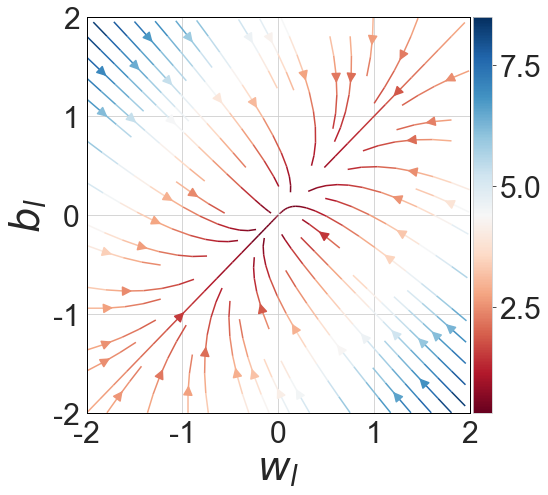

In [2]:
# Plot Specifics
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.locator_params(nbins=3)
    return cbar
fig = plt.figure(figsize=(16,16))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)


# Vector Fields
n = 2

def sa_noise(w, b, sigma):
    dw = b - w + np.random.normal(scale=sigma, size=w.shape)
    db = w - b + np.random.normal(scale=sigma, size=b.shape)
    return dw, db

def sa(w, b):
    dw = b - w
    db = w - b
    return dw, db

def aa(w, b, x):
    dw = x**2 * (b - w)
    db = x**2 * (w - b)
    return dw, db

def wm(w, b, lamb, x):
    dw = x**2 * b - lamb * w
    db = x**2 * w - lamb * b
    return dw, db

def wm2(w, b, x):
    dw = x**2 * b - w * (x**2 * w * b)
    db = x**2 * w -  b * (x**2 * w * b)
    return dw, db

def ia(w, b, lamb, x):
    dw = x**2 * b - x**2 * b**2 * w - lamb * w
    db = x**2 * w  - x**2 * w**2 * b - lamb * b
    return dw, db

w, b = np.meshgrid(np.linspace(-n, n, 10), np.linspace(-n, n, 10))
# dw, db = sa(w, b)
# dw, db = sa_noise(w, b, 1)
# dw, db = aa(w, b, 1) 
# dw, db = wm(w, b, 0.5, 1)
dw, db = wm(w, b, 2, 1)
# dw, db = wm(w, b, 1, 1)
# dw, db = wm2(w, b, 1)
# dw, db = ia(w, b, 0.5, 1)
# dw, db = ia(w, b, 2, 1)
M = np.hypot(dw, db)

# Plot
ax = fig.add_subplot(221)
plt.xlim(-n, n)
plt.ylim(-n, n)
ax.set_xlabel('$w_l$', size=40, weight='light')
ax.set_ylabel('$b_l$', size=40, weight='light')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_yticks([-n,-n/2,0,n/2,n])
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xticks([-n,-n/2,0,n/2,n])
strm = plt.streamplot(w, b, dw, db, color=M, cmap='RdBu', arrowsize=2, density=0.75)
colorbar(strm.lines)
# plt.quiver(w, b, dw, db)
for edge in ['bottom','top','right','left']:
    ax.spines[edge].set_linewidth(1)
    ax.spines[edge].set_color('k')
plt.savefig('wm-large.pdf', format='pdf', bbox_inches='tight')